In [197]:
import json
import numpy as np
import matplotlib.pyplot as plt
import time

debug_level = 0
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Aggregation of all line solutions, represented as statistical distribution 
# 1.0 - always set,  0.0 - always unset 
class Variants:
    def __init__(self, variants):
        self.aggregate = None
        self.count = 0
        for var in variants:
            if self.aggregate is None:
                self.aggregate = np.zeros((var.sum()))
            self.aggregate += var.unpack()
            self.count += 1
        if self.count:
            self.aggregate /= self.count
    def __repr__(self):
        return f"Variants {self.aggregate}"
        
# Packed representation of one line solution
# Even colums represent unset field, odd colums represent set fields
# [0, 1, 3, 2] represents [.X...XX]
class Variant:
    unpacks_done = 0
    def __init__(self, list):
        self.list = list
        self.unpacked = None
    def __repr__(self):
        return f"Variant {self.str()} {[x for x in self.list]}"
    def str(self):
        out = ""
        for i in self.unpack():
            out += 'X' if i else '.'
        return out
    def sum(self):
        return sum(self.list)
    # Unpack to array where 1: occupied, 0: empty
    def unpack(self):
        if self.unpacked is None:
            self.unpacked = np.zeros(sum(self.list))
            index = 0
            for i in range(len(self.list)):
                for j in range(self.list[i]):
                    self.unpacked[index] = 1 if i%2 else 0
                    index += 1
            Variant.unpacks_done += 1
        return self.unpacked
    # Is compatible with already laid down pieces?
    def can_fit(self, known_pieces):
        if not len(known_pieces): return True
        unpacked = self.unpack()
        # if len(known_pieces) != len(unpacked): return False
        for i,j in zip(unpacked, known_pieces):
            if (j==1 or j==0) and (i!=j): return False
        return True
    
        
# Given specification of one line (row or column). E.g. [1,5,2]
class Seq:
    def __init__(self, list):
        self.list = list
        self.cached = None
    def __repr__(self):
        return f"Seq {self.list}"
    # partial - partially built list of this combination
    def variants(self, width, known_pieces=[], partial=[]):  
        if self.cached is None:
            self.cached = [variant for variant in self.gather_variants(width, known_pieces, partial) if variant.can_fit(known_pieces)]
        for variant in self.cached:
            if variant.can_fit(known_pieces): 
                yield variant 
            
        
    def gather_variants(self, width, known_pieces, partial=[]):  
        if debug_level > 1: print(f'remain={self.list}, partial={partial}')
        if not Variant(partial).can_fit(known_pieces):
            return
        if not self.list:
            # Successfully emptied all requirements
            finished = Variant(partial + [width - sum(partial)])
            if finished.can_fit(known_pieces):
                yield finished
            return
        # Item that will be placed
        first = self.list[0]
        # Minimum space needed to fit all the remaining ones
        reserved = sum(self.list[1:]) + len(self.list[1:])
        for i in range(0 if not partial else 1, 1 + width - (first + reserved + sum(partial))):
            yield from Seq(self.list[1:]).gather_variants(width, known_pieces, partial + [i, first])
            
    def variant_count(self, width):
        space, needles = (width - (len(self.list)-2 + sum(self.list)), len(self.list))
        return int(np.math.factorial(space + needles - 1) / (np.math.factorial(space-1) * np.math.factorial(needles)))
        

# Solving matrix
class Field:
    def __init__(self, rows, cols):
        self.rows = rows
        self.cols = cols
        self.mat = np.full((len(self.rows), len(self.cols)), 0.5)
        self.npass = 0
    def __repr__(self):
        return f'{self.mat}'
    def solve_step(self):
        # Odd passes - rows. Even passes - columns
        previous_mat = self.mat.copy()
        for _ in range(2):
            is_col = self.npass % 2 == 1
            if debug_level > 0: print("column pass") if is_col else print("row pass")
            if is_col:
                lines = self.cols
                length = self.mat.shape[0]
            else:
                lines = self.rows
                length = self.mat.shape[1]

            if debug_level > 1: print(f'{length=}, {lines=}')

            # Find the least complex line - sort by complexity
            lines = sorted([(i,line) for i,line in enumerate(lines)], key = lambda t: t[1].variant_count(length)) 

            changed = None       
            for i, line in lines:
                # if changed: break
                known_pieces = self.mat[:,i] if is_col else self.mat[i,:]
                # print(f'{known_pieces=}')
                if not 0.5 in known_pieces: continue # Already solved
                variants = Variants(line.variants(length, known_pieces))
                if debug_level > 1: print(variants)
                for j in range(len(variants.aggregate)):
                    prob = variants.aggregate[j]
                    if prob == 0 or prob == 1:
                        row = j if is_col else i
                        col = i if is_col else j
                        if (self.mat[row,col] != prob):
                            changed = ((row, col), (self.mat[row,col], prob))
                            self.mat[row,col] = prob

            self.npass += 1

        return (previous_mat != self.mat).any()
    
    def visualize(self):
        fig, ax = plt.subplots(figsize=(2, 8))
        ax.pcolormesh(self.mat, cmap='terrain_r')
        ax.set_aspect('equal')
        ax.set_xlim(0, self.mat.shape[1])
        ax.set_ylim(self.mat.shape[0], 0)
        plt.show()

In [198]:
debug_level = 0
print(Variants(Seq([2,1,1]).variants(7))) # All possibilities
print(Variants(Seq([2,1,1]).variants(7, [0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5 ]))) # Filtered by known pieces
[variant for variant in Seq([1,1,1]).variants(7)]

elems = [3, 1, 2, 1]
width = 12
print(len([print(variant) for variant in Seq(elems).variants(width)]))

# Discovering with a solid mathematical formula to count the number of variants
def space_needles(elems, width):
    return (width - (len(elems)-2 + sum(elems)), len(elems))
def complexity(elems, width):
    space, needles = space_needles(elems, width)
    return adversity(needles, space)
def adversity(needles, space):
    print((needles, space))
    if needles == 1: return space
    if space == 0: return 0
    return sum([adversity(needles-1, i) for i in range(space, 0, -1)])
def sensibility(elems, width):
    space, needles = space_needles(elems, width)
    return int(np.math.factorial(space + needles - 1) / (np.math.factorial(space-1) * np.math.factorial(needles)))

# print(f'Complex: {complexity(elems, width)}')
# print(f'Sense: {sensibility(elems, width)}')
print(f'VarCount: {Seq(elems).variant_count(width)}')

Variants [0.75 1.00 0.25 0.50 0.50 0.25 0.75]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [195]:
# Read test data and solve
with open('gridler.test.json.txt') as f:
    data = json.load(f)

rows = [Seq(row) for row in data['rows']]
cols = [Seq(col) for col in data['columns']]
field = Field(rows, cols)



time taken: 3.452 s (total 3.452 s) 


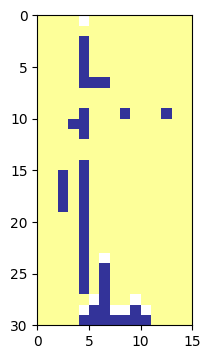

time taken: 0.634 s (total 4.086 s) 
time taken: 0.379 s (total 4.465 s) 
time taken: 0.358 s (total 4.823 s) 
time taken: 0.342 s (total 5.166 s) 
time taken: 0.368 s (total 5.534 s) 
time taken: 0.321 s (total 5.855 s) 
time taken: 0.319 s (total 6.173 s) 
time taken: 0.213 s (total 6.387 s) 
time taken: 0.182 s (total 6.569 s) 
time taken: 0.138 s (total 6.707 s) 


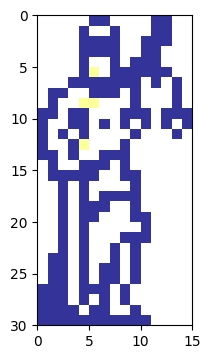

time taken: 0.156 s (total 6.863 s) 


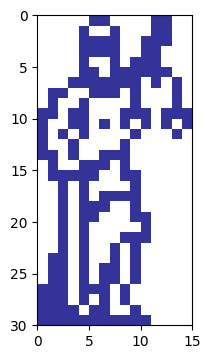

Solved (without branching)
 in 6.956 s
Variant.unpacks_done=580732


In [196]:
start = time.perf_counter()
prev = start
step = 0
Variant.unpacks_done = 0
while field.solve_step():
    step += 1
    print(f'time taken: {time.perf_counter() - prev:.3f} s (total {time.perf_counter() - start:.3f} s) ')
    prev = time.perf_counter()
    if step % 10 == 1: field.visualize()

field.visualize()
print("Solved (without branching)") if not 0.5 in field.mat else print("Unsolved")
print(f" in {time.perf_counter() - start:.3f} s")
print(f"{Variant.unpacks_done=}")

# Current state:
#  Slow
#  Has to walk through all possibilites
#  No branching support 
#  Can't handle big matrixes
#  Hopefully correct :-)